In [37]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.datasets as TVdatasets

import torchattacks

from tqdm.notebook import tqdm

import clip
import importlib

In [23]:
a = torch.randn(3,5)
print(a)
softmax_obj = torch.nn.Softmax(dim=1)

tensor([[ 0.6117,  1.3922,  0.1779,  1.0626, -1.3172],
        [ 0.6346,  0.2016, -0.3593, -0.7211, -0.1761],
        [-1.4016,  0.4957, -0.2529,  0.0770, -1.3667]])


In [28]:
b = torch.log(softmax_obj(a))
print(b)

tensor([[-1.7130, -0.9325, -2.1468, -1.2621, -3.6419],
        [-1.0010, -1.4340, -1.9949, -2.3567, -1.8117],
        [-2.7878, -0.8904, -1.6391, -1.3091, -2.7528]])


In [29]:
labels = torch.tensor([1,2,4])

In [26]:
torch.sum(b, dim=1)

tensor([-9.6963, -8.5984, -9.3792])

In [32]:
b[range(3), labels]

tensor([-0.9325, -1.9949, -2.7528])

In [35]:
c = torch.sum(b, dim=1) - 2*b[range(3),labels]

In [36]:
torch.mean(c)

tensor(-5.4378)

In [75]:
importlib.reload(torchattacks.attack)
importlib.reload(torchattacks.attack_methods.fgsm)
importlib.reload(torchattacks.attack_methods.ffgsm)
importlib.reload(torchattacks.attack_methods.pgd)

<module 'torchattacks.attack_methods.pgd' from '/home/sazim/ICLR23/adv_attacks/code/torchattacks/attack_methods/pgd.py'>

### Define device type

In [40]:
# define device type - cuda:0 or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device.type == "cuda" else {}
# print(kwargs)

# Additional Info when using cuda
if device.type == 'cuda':
    print("Number of GPU devices:", torch.cuda.device_count())
    print("GPU device name:", torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Number of GPU devices: 1
GPU device name: GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Load CLIP Model

In [41]:
def load_CLIP_pretrained_model(model_name):
    model, preprocess_transform = clip.load(model_name)
    return model, preprocess_transform

### Load MNIST data

In [42]:
def load_MNIST_data(train_batch_size, test_batch_size, preprocess, kwargs):
    mnist_transform = transforms.Compose([transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor()])

    mnist_train_data = TVdatasets.MNIST(root='../data/', 
                                        train=True,
                                        transform=preprocess,
                                        download=True)

    mnist_test_data = TVdatasets.MNIST(root='../data/',
                                      train=False,
                                      transform=preprocess,
                                      download=True)

    print("Number of train samples:", len(mnist_train_data))
    print("Number of test samples:", len(mnist_test_data))

    trainloader = torch.utils.data.DataLoader(dataset=mnist_train_data,
                                             batch_size=train_batch_size,
                                             shuffle=True,
                                             **kwargs)

    testloader = torch.utils.data.DataLoader(dataset=mnist_test_data,
                                            batch_size=test_batch_size,
                                            shuffle=True,
                                            **kwargs)
    
    return trainloader, testloader

### Show model overview details

In [43]:
def model_overview_desc(model):
    input_resolution = model.visual.input_resolution
    context_length = model.context_length
    vocab_size = model.vocab_size
    
    num_parameters = 0
    for p in model.parameters():
        num_parameters += np.prod(p.shape)

    print("Image input resolution:", input_resolution)
    print("Text desc context length:", context_length)
    print("Vocab size:", vocab_size)
    print("Number of model parameters:", int(num_parameters))

### Show sample images

In [44]:
def get_sample_imgs(dataloader, num_imgs=8):
#     sample_imgs = []
#     sample_labels = []

    for _, (batch_imgs, batch_labels) in enumerate(dataloader):
#         batch_imgs = batch_imgs.repeat(1, 3, 1, 1)
        for i in range(num_imgs):
            batch_imgs[i] = (batch_imgs[i] - batch_imgs[i].min()) / (batch_imgs[i].max() - batch_imgs[i].min())

        sample_imgs = batch_imgs[0:num_imgs]
        sample_gt_labels = batch_labels[0:num_imgs]
        
        break

#         test_sample_imgs.append(batch_imgs[i])
#         test_sample_labels.append(batch_labels[i])
    
    return sample_imgs, sample_gt_labels

In [45]:
def show_sample_imgs(imgs, classnames, gt_labels, model_pred):
    plt.figure(figsize=(14, 7))
    num_imgs = imgs.shape[0]
    
    if imgs.shape[1] == 3:
        imgs = np.transpose(imgs, (0,2,3,1))
    
    for i in range(num_imgs):
        plt.subplot(2, 4, i+1)
        plt.imshow(imgs[i])
        plt.title("GT: {}, Pred: {}".format(classnames[gt_labels[i]], classnames[model_pred[i]]))
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.show()

### Text descriptions based on classnames (prompt engineering)

In [46]:
def get_text_descriptions(classnames, text_templates):
    text_descriptions = []

    for class_name in classnames:
        for template in text_templates:
            text_descriptions.append(template.format(class_name))

    return text_descriptions

### Predict zero-shot classification for MNIST sample images using CLIP

In [47]:
def construct_similarity_map(model, batch_imgs, text_descriptions):
    batch_imgs = batch_imgs.to(device)
    text_tokens = clip.tokenize(text_descriptions).to(device)

#     print("Stacked images shape:", batch_imgs.shape)
#     print("Tokenized text shape:", text_tokens.shape)

    with torch.no_grad():
        img_features = model.encode_image(batch_imgs).float()
        text_features = model.encode_text(text_tokens).float()

#     print("Encoded images shape:", img_features.shape)
#     print("Encoded text shape:", text_features.shape)
    
    # each encoded image or text is a 512-dim feature vector in the embedding space
    # for each encoded image or text feature, divide by its length to make it a unit length vector
    img_features = img_features / torch.linalg.norm(img_features, dim=1, keepdim=True)
    text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

    similarity_map = torch.matmul(img_features, text_features.T)
#     print("Cosine similarity map shape:", similarity_map.shape)
#     print(similarity_map.min(), similarity_map.max())
    
    return similarity_map

In [48]:
def plot_similarity_map(similarity_map, sample_imgs, text_descriptions):
    num_imgs = similarity_map.shape[1]
    num_texts = similarity_map.shape[0]

    plt.figure(figsize=(20, 12))
    plt.imshow(similarity_map, vmin=0.1, vmax=0.3)

    plt.yticks(range(num_texts), text_descriptions, fontsize=14)
    plt.xticks([])

    if sample_imgs.shape[1] == 3:
        sample_imgs = np.transpose(sample_imgs, (0,2,3,1))

    for idx, img in enumerate(sample_imgs):
#         img = np.transpose(img, (1,2,0))
        plt.imshow(img, extent=(idx - 0.5, idx + 0.5, -1.6, -0.6), origin="lower")

    for x in range(num_imgs):
        for y in range(num_texts):
            plt.text(x, y, f"{similarity_map[y, x]:.4f}", ha="center", va="center", size=10)

    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, num_texts - 0.5])
    plt.ylim([num_texts + 0.5, -2])

    plt.title("Cosine similarity map between text and image features", size=16)

### Computing standard clean ZS accuracy of CLIP on MNIST test data

In [49]:
def compute_test_accuracy(model, dataloader, text_descriptions):
    num_corr_pred = 0
    num_samples = 0
    model.eval()

    for itr, (batch_imgs, batch_labels) in enumerate(tqdm(dataloader)):
#         batch_imgs = batch_imgs.repeat(1,3,1,1)
        batch_imgs = batch_imgs.to(device)
        batch_labels = batch_labels.to(device)

        similarity_map = construct_similarity_map(model, batch_imgs, text_descriptions)
        batch_pred = torch.argmax(similarity_map, dim=1)

        num_corr_pred += float((batch_pred == batch_labels).sum())
        num_samples += batch_imgs.shape[0]

    test_accuracy = round(100.0 * num_corr_pred / num_samples, 4)
    
    return test_accuracy

## CLIP + MNIST

In [50]:
# print all available CLIP pretrained models and load one of the models
print("Available CLIP pretrained models:", clip.available_models())
model_CLIP, preprocess_CLIP = load_CLIP_pretrained_model("ViT-B/32")
print("\nImage Preprocessing Transform:\n", preprocess_CLIP)

# send model to device (cuda/cpu)
model_CLIP = model_CLIP.to(device)
model_CLIP.eval()

# describe model details
model_overview_desc(model_CLIP)

Available CLIP pretrained models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']

Image Preprocessing Transform:
 Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fdede8de940>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
Image input resolution: 224
Text desc context length: 77
Vocab size: 49408
Number of model parameters: 151277313


In [51]:
# load MNIST dataset
train_batch_size = 32
test_batch_size = 32
trainloader, testloader = load_MNIST_data(train_batch_size, test_batch_size, preprocess_CLIP, kwargs)

# get MNIST text descriptions (classnames + text templates)
# mnist_classes = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
text_templates = ['a photo of digit {}']
text_descriptions = get_text_descriptions(mnist_classes, text_templates)

Number of train samples: 60000
Number of test samples: 10000


### Sample MNIST images

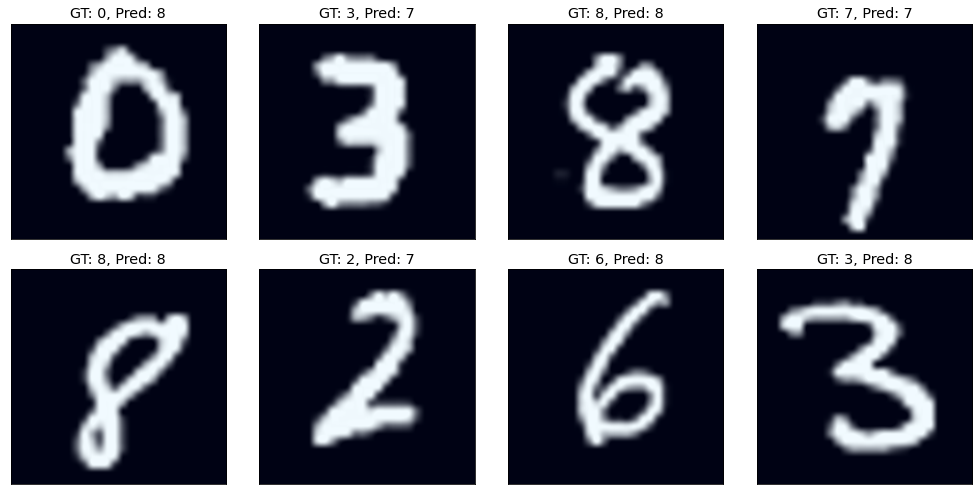

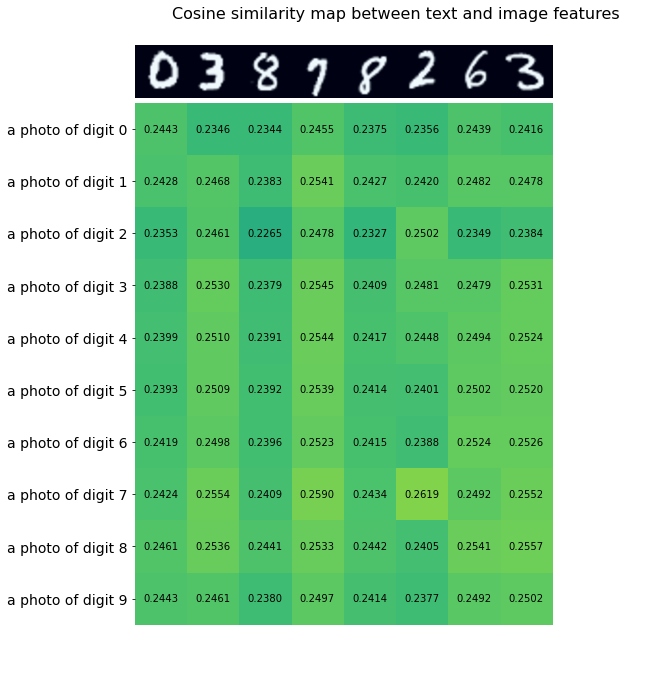

In [52]:
# show sample MNIST images
sample_imgs, sample_gt_labels = get_sample_imgs(testloader, num_imgs=8)

# construct similarity map for (sample images, class descriptions)
sim_map = construct_similarity_map(model_CLIP, sample_imgs, text_descriptions)

# predict CLIP model output on sample images
sample_pred = torch.argmax(sim_map, dim=1)

show_sample_imgs(sample_imgs, mnist_classes, sample_gt_labels, sample_pred)

plot_similarity_map(sim_map.cpu().numpy().T, sample_imgs, text_descriptions)

### ZS-CLIP test accuracy on MNIST testset

In [53]:
start_time = time.time()
test_acc = compute_test_accuracy(model_CLIP, testloader, text_descriptions)
print("Standard clean ZS-CLIP accuracy on MNIST testset: {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/313 [00:00<?, ?it/s]

Standard clean ZS-CLIP accuracy on MNIST testset: 22.46 %
Time taken: 8.38 s


### Sample MNIST adversarial images (FGSM)

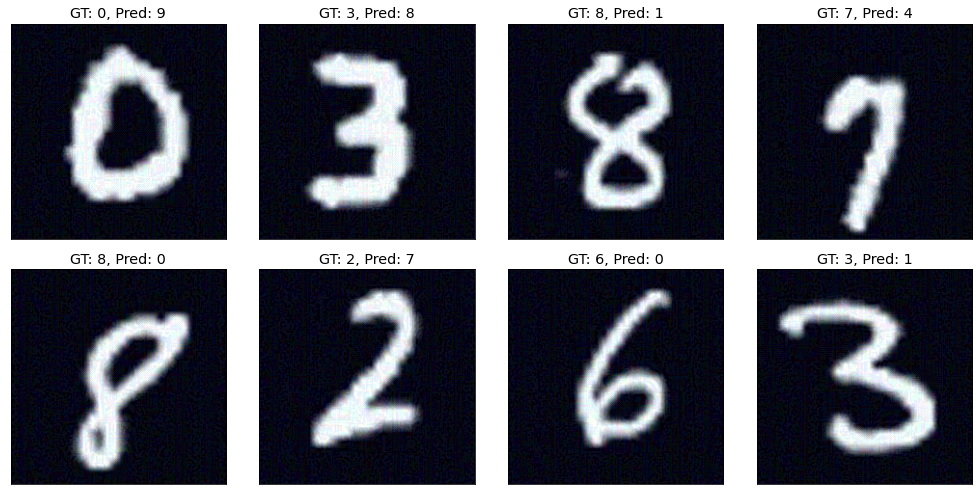

In [65]:
fgsm_attack = torchattacks.attack_methods.fgsm.FGSM_CLIP(model_CLIP, eps=10/255)

text_tokens = clip.tokenize(text_descriptions).to(device)
text_features = model_CLIP.encode_text(text_tokens).float()
text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

sample_adv_imgs = fgsm_attack(sample_imgs, sample_gt_labels, text_features)

# construct similarity map for (sample images, class descriptions)
sim_map = construct_similarity_map(model_CLIP, sample_adv_imgs, text_descriptions)

# predict CLIP model output on sample images
sample_pred = torch.argmax(sim_map, dim=1)

show_sample_imgs(sample_adv_imgs.cpu().numpy(), mnist_classes, sample_gt_labels, sample_pred)

### ZS-CLIP test accuracy on FGSM attacked MNIST testset

In [66]:
start_time = time.time()

num_samples = 0
num_corr_pred = 0
model_CLIP.eval()

text_tokens = clip.tokenize(text_descriptions).to(device)
text_features = model_CLIP.encode_text(text_tokens).float()
text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)

    X_test = fgsm_attack(batch_imgs, batch_labels, text_features)
    Y_test_gt = batch_labels

    # compute model prediction
    img_features = model_CLIP.encode_image(X_test).float()
    img_features = img_features / torch.linalg.norm(img_features, dim=1, keepdim=True)

    similarity_map = torch.matmul(img_features, text_features.T)
    Y_test_pred = torch.argmax(similarity_map, dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += float((Y_test_pred == Y_test_gt).sum())

test_acc = round(100.0 * num_corr_pred / num_samples, 4)

print("Robust ZS-CLIP accuracy on MNIST testset (FGSM attack): {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust ZS-CLIP accuracy on MNIST testset (FGSM attack): 17.43 %
Time taken: 23.44 s


## CLIP + CIFAR10

In [67]:
def load_CIFAR10_data(train_batch_size, test_batch_size, preprocess, kwargs):
    cifar10_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

    cifar10_train_data = TVdatasets.CIFAR10(root="/datasets/CIFAR-10/", 
                                            train=True, 
                                            download=True, 
                                            transform=preprocess)

    cifar10_test_data = TVdatasets.CIFAR10(root="/datasets/CIFAR-10/", 
                                           train=False, 
                                           download=True, 
                                           transform=preprocess)

    print("Number of train samples:", len(cifar10_train_data))
    print("Number of test samples:", len(cifar10_test_data))

    trainloader = torch.utils.data.DataLoader(dataset=cifar10_train_data,
                                             batch_size=train_batch_size,
                                             shuffle=True,
                                             **kwargs)

    testloader = torch.utils.data.DataLoader(dataset=cifar10_test_data,
                                             batch_size=test_batch_size,
                                             shuffle=True,
                                            **kwargs)

    return trainloader, testloader

### Load CIFAR10 data

In [68]:
# load CIFAR10 dataset
train_batch_size = 32
test_batch_size = 32
trainloader, testloader = load_CIFAR10_data(train_batch_size, test_batch_size, preprocess_CLIP, kwargs)

# get CIFAR10 text descriptions (classnames + text templates)
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
text_templates = ['a photo of a {}']
text_descriptions = get_text_descriptions(cifar10_classes, text_templates)

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000


### Sample CIFAR10 images

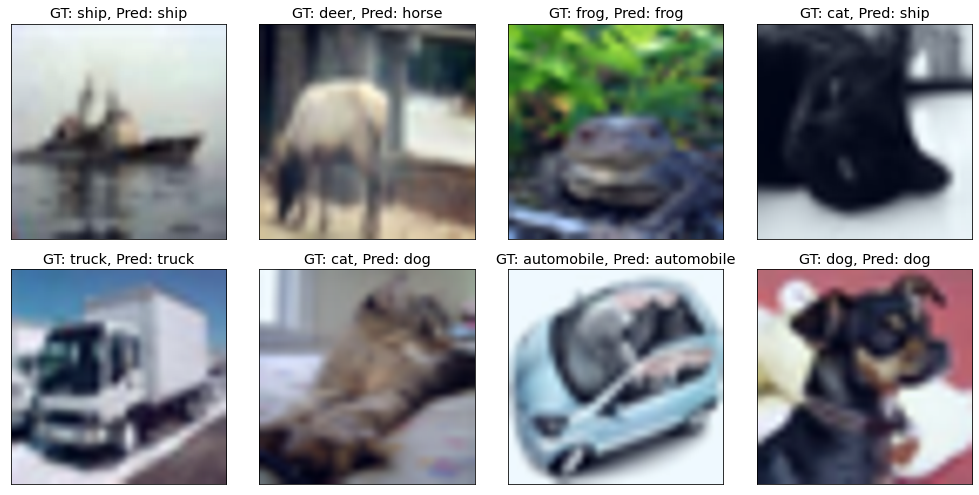

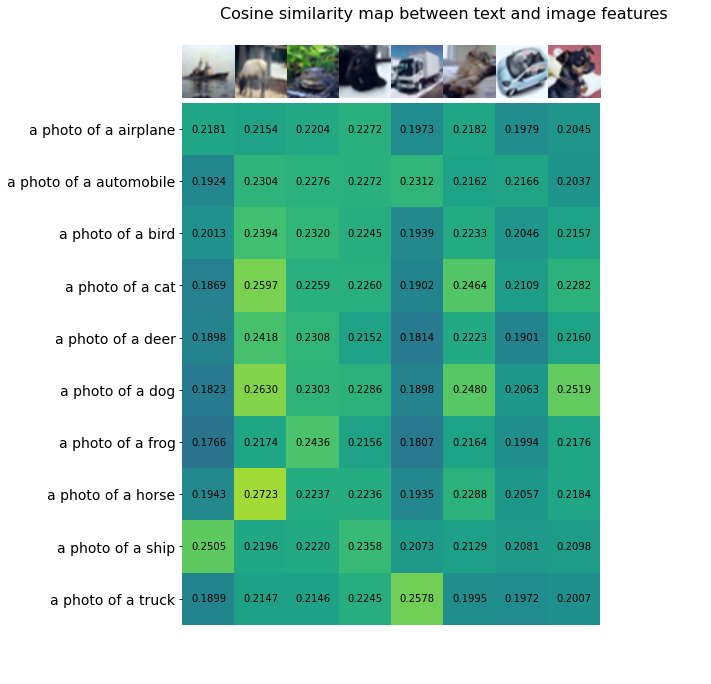

In [76]:
# show sample CIFAR10 images
sample_imgs, sample_gt_labels = get_sample_imgs(testloader, num_imgs=8)

# construct similarity map for (sample images, class descriptions)
sim_map = construct_similarity_map(model_CLIP, sample_imgs, text_descriptions)

# predict CLIP model output on sample images
sample_pred = torch.argmax(sim_map, dim=1)

show_sample_imgs(sample_imgs, cifar10_classes, sample_gt_labels, sample_pred)

plot_similarity_map(sim_map.cpu().numpy().T, sample_imgs, text_descriptions)

### ZS-CLIP test accuracy on CIFAR10 testset

In [84]:
start_time = time.time()
test_acc = compute_test_accuracy(model_CLIP, testloader, text_descriptions)
print("Standard clean ZS-CLIP accuracy on CIFAR10 testset: {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/313 [00:00<?, ?it/s]

Standard clean ZS-CLIP accuracy on CIFAR10 testset: 88.77 %
Time taken: 9.79 s


### Sample CIFAR10 adversarial images (FGSM)

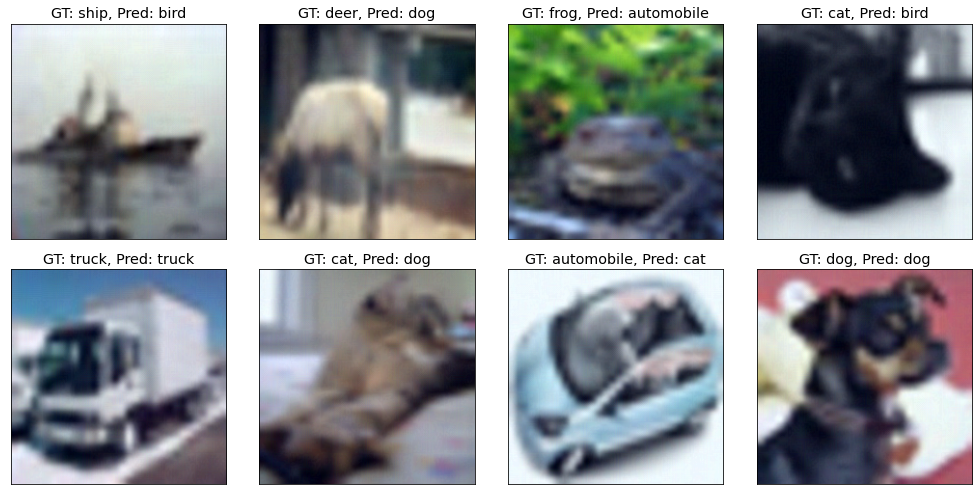

In [78]:
fgsm_attack = torchattacks.attack_methods.fgsm.FGSM_CLIP(model_CLIP, eps=2/255)

text_tokens = clip.tokenize(text_descriptions).to(device)
text_features = model_CLIP.encode_text(text_tokens).float()
text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

sample_adv_imgs = fgsm_attack(sample_imgs, sample_gt_labels, text_features)

# construct similarity map for (sample images, class descriptions)
sim_map = construct_similarity_map(model_CLIP, sample_adv_imgs, text_descriptions)

# predict CLIP model output on sample images
sample_pred = torch.argmax(sim_map, dim=1)

show_sample_imgs(sample_adv_imgs.cpu().numpy(), cifar10_classes, sample_gt_labels, sample_pred)

### ZS-CLIP test accuracy on FGSM attacked CIFAR10 testset

In [79]:
start_time = time.time()

num_samples = 0
num_corr_pred = 0
model_CLIP.eval()

text_tokens = clip.tokenize(text_descriptions).to(device)
text_features = model_CLIP.encode_text(text_tokens).float()
text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)

    X_test_adv = fgsm_attack(batch_imgs, batch_labels, text_features)
    Y_test_gt = batch_labels

    # compute model prediction
    img_features = model_CLIP.encode_image(X_test_adv).float()
    img_features = img_features / torch.linalg.norm(img_features, dim=1, keepdim=True)

    similarity_map = torch.matmul(img_features, text_features.T)
    Y_test_pred = torch.argmax(similarity_map, dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += float((Y_test_pred == Y_test_gt).sum())

test_acc = round(100.0 * num_corr_pred / num_samples, 4)

print("Robust ZS-CLIP accuracy on CIFAR10 testset (FGSM attack): {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust ZS-CLIP accuracy on CIFAR10 testset (FGSM attack): 49.49 %
Time taken: 23.38 s


### Sample CIFAR10 adversarial images (Fast-FGSM)

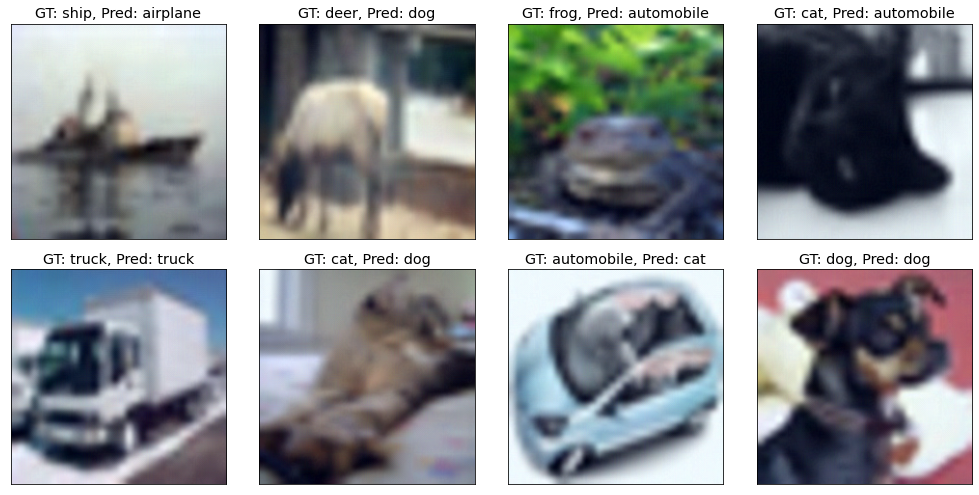

In [80]:
ffgsm_attack = torchattacks.attack_methods.ffgsm.FFGSM_CLIP(model_CLIP, eps=2/255, alpha=2/255)

text_tokens = clip.tokenize(text_descriptions).to(device)
text_features = model_CLIP.encode_text(text_tokens).float()
text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

sample_adv_imgs = ffgsm_attack(sample_imgs, sample_gt_labels, text_features)

# construct similarity map for (sample images, class descriptions)
sim_map = construct_similarity_map(model_CLIP, sample_adv_imgs, text_descriptions)

# predict CLIP model output on sample images
sample_pred = torch.argmax(sim_map, dim=1)

show_sample_imgs(sample_adv_imgs.cpu().numpy(), cifar10_classes, sample_gt_labels, sample_pred)

### ZS-CLIP accuracy on Fast-FGSM attacked CIFAR10 testset

In [81]:
start_time = time.time()

num_samples = 0
num_corr_pred = 0
model_CLIP.eval()

text_tokens = clip.tokenize(text_descriptions).to(device)
text_features = model_CLIP.encode_text(text_tokens).float()
text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)

    X_test_adv = ffgsm_attack(batch_imgs, batch_labels, text_features)
    Y_test_gt = batch_labels

    # compute model prediction
    img_features = model_CLIP.encode_image(X_test_adv).float()
    img_features = img_features / torch.linalg.norm(img_features, dim=1, keepdim=True)

    similarity_map = torch.matmul(img_features, text_features.T)
    Y_test_pred = torch.argmax(similarity_map, dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += float((Y_test_pred == Y_test_gt).sum())

test_acc = round(100.0 * num_corr_pred / num_samples, 4)

print("Robust ZS-CLIP accuracy on CIFAR10 testset (Fast-FGSM attack): {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust ZS-CLIP accuracy on CIFAR10 testset (Fast-FGSM attack): 21.82 %
Time taken: 23.44 s


### Sample CIFAR10 adversarial images (PGD)

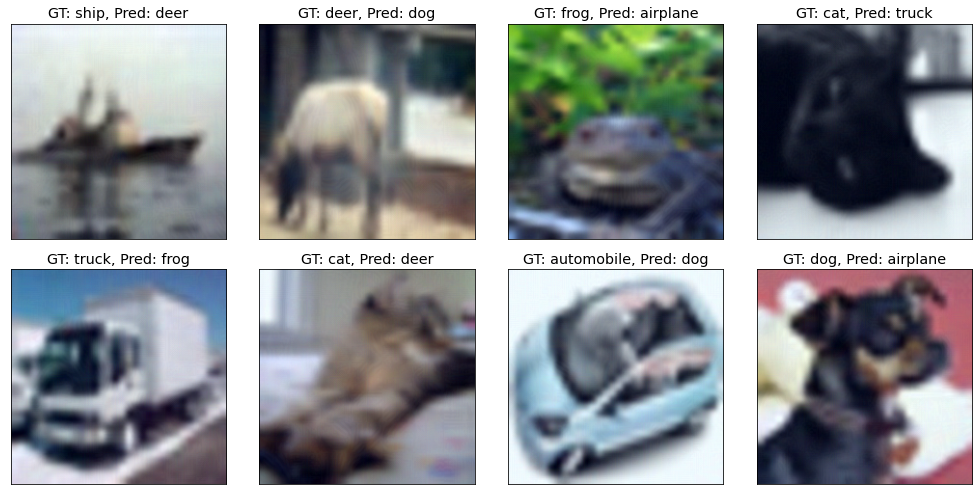

In [82]:
pgd_attack = torchattacks.attack_methods.pgd.PGD_CLIP(model_CLIP, eps=2/255, alpha=2/255, steps=20)

text_tokens = clip.tokenize(text_descriptions).to(device)
text_features = model_CLIP.encode_text(text_tokens).float()
text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

sample_adv_imgs = pgd_attack(sample_imgs, sample_gt_labels, text_features)

# construct similarity map for (sample images, class descriptions)
sim_map = construct_similarity_map(model_CLIP, sample_adv_imgs, text_descriptions)

# predict CLIP model output on sample images
sample_pred = torch.argmax(sim_map, dim=1)

show_sample_imgs(sample_adv_imgs.cpu().numpy(), cifar10_classes, sample_gt_labels, sample_pred)

### ZS-CLIP accuracy on PGD attacked CIFAR10 testset

In [83]:
start_time = time.time()

num_samples = 0
num_corr_pred = 0
model_CLIP.eval()

text_tokens = clip.tokenize(text_descriptions).to(device)
text_features = model_CLIP.encode_text(text_tokens).float()
text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)

    X_test_adv = pgd_attack(batch_imgs, batch_labels, text_features)
    Y_test_gt = batch_labels

    # compute model prediction
    img_features = model_CLIP.encode_image(X_test_adv).float()
    img_features = img_features / torch.linalg.norm(img_features, dim=1, keepdim=True)

    similarity_map = torch.matmul(img_features, text_features.T)
    Y_test_pred = torch.argmax(similarity_map, dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += float((Y_test_pred == Y_test_gt).sum())

test_acc = round(100.0 * num_corr_pred / num_samples, 4)

print("Robust ZS-CLIP accuracy on CIFAR10 testset (PGD attack): {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust ZS-CLIP accuracy on CIFAR10 testset (PGD attack): 5.96 %
Time taken: 316.92 s


## CLIP + ImageNet

In [48]:
!pip3 install imagenetv2_pytorch

ERROR: Could not find a version that satisfies the requirement imagenetv2_pytorch (from versions: none)
ERROR: No matching distribution found for imagenetv2_pytorch


In [57]:
# from imagenetv2_pytorch import ImageNetV2Dataset

# images = ImageNetV2Dataset(transform=preprocess_CLIP)
# loader = torch.utils.data.DataLoader(images, batch_size=32, num_workers=2)

In [25]:
# imagenet_datapath = "/datasets/imagenet-ds/valid_64x64/"
# imagenet_datapath = "../data/ImageNet/"
imagenet_datapath = "/datasets/Tiny-ImageNet/tiny-imagenet-200/"

In [26]:
def load_ImageNet_data(train_batch_size, test_batch_size, preprocess, kwargs):
    imagenet_test_data = TVdatasets.ImageNet(root=imagenet_datapath, 
                                             split='val',
                                             transform=preprocess)
    
    print("Number of test samples:", len(imagenet_test_data))

    imagenet_testloader = torch.utils.data.DataLoader(dataset=imagenet_test_data, 
                                                      batch_size=test_batch_size, 
                                                      shuffle=True, 
                                                      **kwargs)

    return imagenet_testloader

In [27]:
train_batch_size = 32
test_batch_size = 32

load_ImageNet_data(train_batch_size, test_batch_size, preprocess_CLIP, kwargs)

RuntimeError: The archive ILSVRC2012_devkit_t12.tar.gz is not present in the root directory or is corrupted. You need to download it externally and place it in /datasets/Tiny-ImageNet/tiny-imagenet-200/.